In [2]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

## Checking fine tuned predictions

In [4]:
df_finetuned = pd.read_json('C:/Users/oryan/Documents/zoobot_new/model-logs/2022-05-05-HEC-all-unfrozen-0.89/2022-04-04-HEC_finetuned_result_timestamped_5254_8580.json')

In [5]:
predictions_finetuned = df_finetuned[['predictions','labels']]

In [6]:
cutoff_range = np.linspace(0.01,0.99,1000)

In [7]:
predictions_finetuned

,predictions,labels
0,0.163298,1
1,0.999369,1
2,0.347656,0
3,0.529907,0
4,0.999829,1
...,...,...
1309,0.998502,1
1310,0.333489,0
1311,0.994634,1
1312,0.984384,1


In [8]:
def get_accuracy(df, cut):
    df_pred = df.assign(binary_prediction = df.predictions.apply(lambda x: 0 if x <= cut else 1))
    right_df = df_pred.query('binary_prediction == labels')
    accuracy = len(right_df)/len(df_pred)
    return accuracy

In [9]:
accuracy_fine = {}
for i in range(len(cutoff_range)):
    accuracy_fine[cutoff_range[i]] = [get_accuracy(predictions_finetuned, cutoff_range[i])]

In [10]:
accuracy_fine_df = (
    pd.DataFrame(accuracy_fine)
    .T
    .reset_index()
    .rename(columns={'index':'binary_cut',0:'Accuracy'})
)

In [11]:
max_acc = np.max(accuracy_fine_df['Accuracy'])
accuracy_fine_df.query('Accuracy == @max_acc').iloc[-1]

binary_cut    0.451441
Accuracy      0.862253
Name: 450, dtype: float64

In [16]:
accuracy_fine_df.query('Accuracy >= 0.85')

,binary_cut,Accuracy
364,0.367077,0.850076
365,0.368058,0.850076
366,0.369039,0.850076
367,0.370020,0.850076
368,0.371001,0.850076
...,...,...
636,0.633904,0.850837
637,0.634885,0.850837
638,0.635866,0.850837
639,0.636847,0.850076


<AxesSubplot:title={'center':'Accuracy vs Cut in SDSS Example'}, xlabel='Prediction Cutoff', ylabel='Accuracy'>

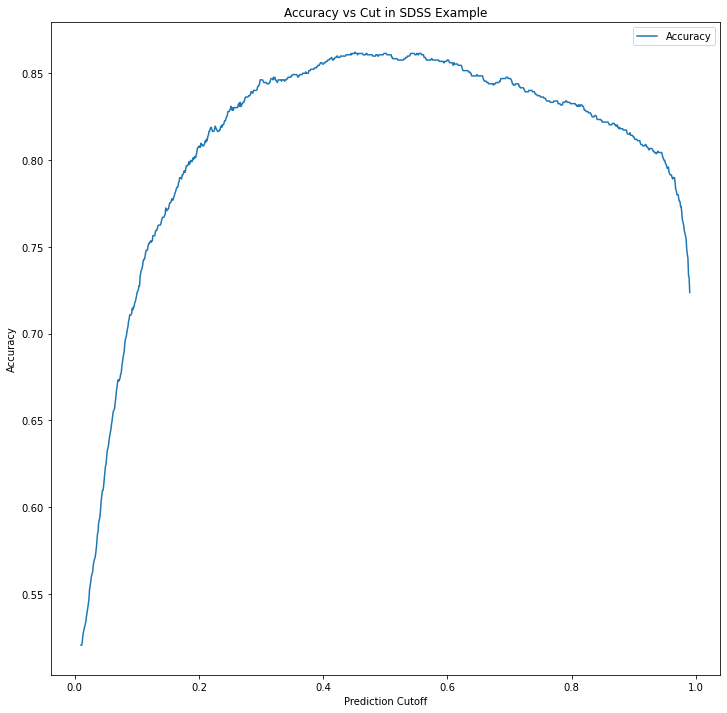

In [12]:
accuracy_fine_df.plot(x='binary_cut',y='Accuracy',figsize=(12,12),xlabel='Prediction Cutoff',ylabel='Accuracy',title='Accuracy vs Cut in SDSS Example')

## Checking Trained Head Data

In [12]:
df_head = pd.read_json('C:/Users/oryan/Documents/zoobot_new/model-logs/2022-05-05-HEC-all-unfrozen-0.87/2022-04-04-HEC_transfer_1_result_timestamped_5254_801.json')

In [13]:
predictions_head = df_head[['predictions','labels']]

In [14]:
predictions_head

,predictions,labels
0,0.475730,1
1,0.927136,1
2,0.802354,0
3,0.310956,0
4,0.879146,1
...,...,...
1309,0.986702,1
1310,0.283839,0
1311,0.615232,1
1312,0.309383,1


In [15]:
accuracy_head = {}
for i in range(len(cutoff_range)):
    accuracy_head[cutoff_range[i]] = [get_accuracy(predictions_head, cutoff_range[i])]

In [16]:
accuracy_head_df = (
    pd.DataFrame(accuracy_head)
    .T
    .reset_index()
    .rename(columns={'index':'binary_cut',0:'Accuracy'})
)

In [17]:
max_acc = np.max(accuracy_head_df['Accuracy'])
accuracy_head_df.query('Accuracy == @max_acc').iloc[-1]

binary_cut    0.606436
Accuracy      0.721461
Name: 608, dtype: float64

<AxesSubplot:title={'center':'Accuracy vs Cut in SDSS Example'}, xlabel='Prediction Cutoff', ylabel='Accuracy'>

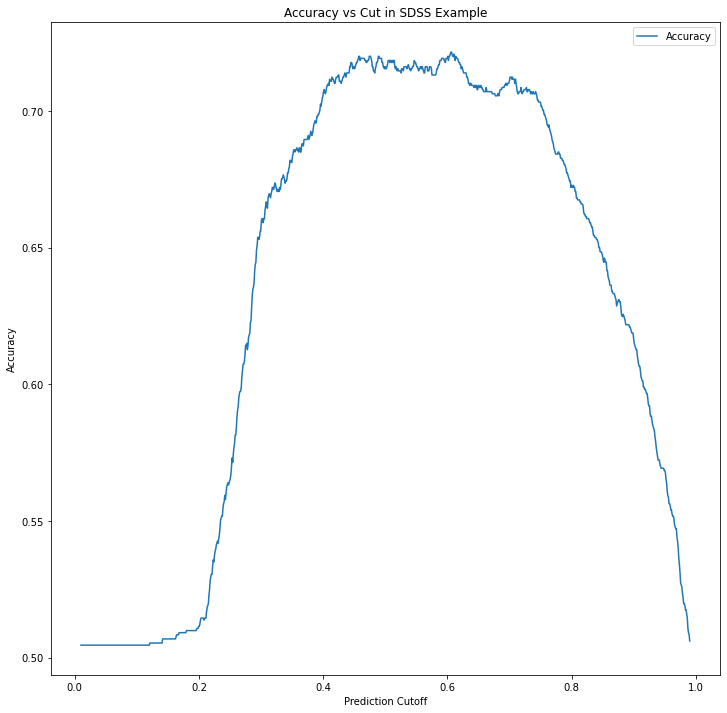

In [18]:
accuracy_head_df.plot(x='binary_cut',y='Accuracy',figsize=(12,12),xlabel='Prediction Cutoff',ylabel='Accuracy',title='Accuracy vs Cut in SDSS Example')

## Comparing these Accuracy Curves

In [19]:
accuracy_head_df

,binary_cut,Accuracy
0,0.010000,0.504566
1,0.010981,0.504566
2,0.011962,0.504566
3,0.012943,0.504566
4,0.013924,0.504566
...,...,...
995,0.986076,0.514460
996,0.987057,0.510654
997,0.988038,0.509132
998,0.989019,0.508371


In [20]:
df_merged = (
    accuracy_head_df
    .merge(accuracy_fine_df,on='binary_cut',how='left')
    .rename(columns={'Accuracy_x':'head_acc','Accuracy_y' : 'fine_acc'})
)

<AxesSubplot:title={'center':'Accuracy vs Cutoff'}, xlabel='Cutoff', ylabel='Accuracy'>

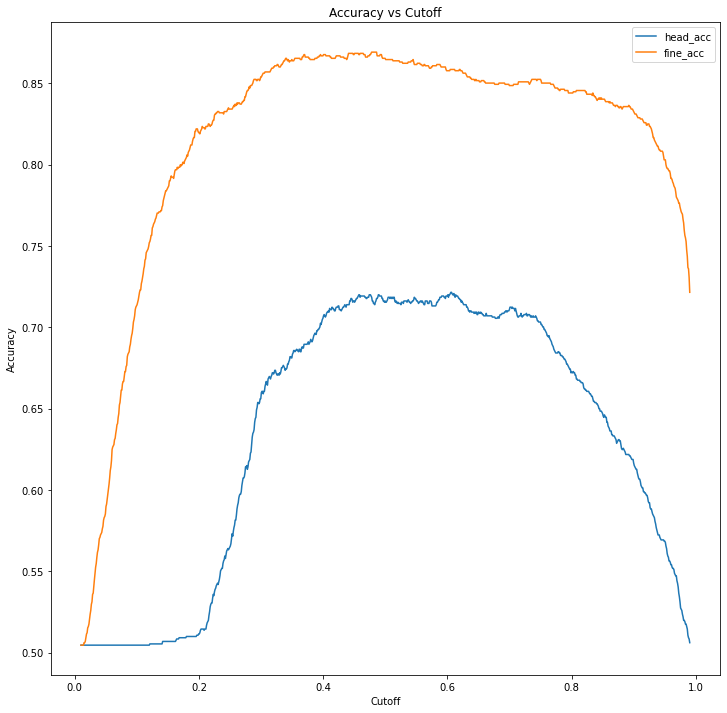

In [21]:
ax = (
    df_merged.plot(
        x = 'binary_cut',
        y = 'head_acc',
        figsize=(12,12),
        title='Accuracy vs Cutoff'
    )
)
df_merged.plot(
    x = 'binary_cut',
    y = 'fine_acc',
    ax=ax,
    ylabel = 'Accuracy',
    xlabel = 'Cutoff',
    legend = ['Head Trained Only', 'Head and Upper Layers Trained']
)

## Generating PR Curves for Head Only

In [22]:
def get_precision(df,cut):
    df_binary = (
        df.assign(binary_prediction = df.predictions.apply(lambda x: 0 if x <= cut else 1))
    )
    tp = len(df_binary.query('labels == 1 & binary_prediction == 1'))
    fp = len(df_binary.query('labels == 0 & binary_prediction == 1'))
        
    try:
        p = tp/(tp + fp)
    except:
        p = np.nan
    
    return p

In [23]:
def get_recall(df, cut):
    df_binary = (
        df.assign(binary_prediction = df.predictions.apply(lambda x: 0 if x <= cut else 1))
    )
    tp = len(df_binary.query('labels == 1 & binary_prediction == 1'))
    fn = len(df_binary.query('labels == 1 & binary_prediction == 0'))
    
    try:
        r = tp/(tp + fn)
    except:
        r = np.nan
    
    return r

In [24]:
cutoffs = np.linspace(0.05, 0.95, 100)

In [25]:
pr = []
for i in cutoffs:
    precision = get_precision(predictions_head, i)
    recall = get_recall(predictions_head,i)
    pr.append([recall, precision])

In [26]:
pr_df = pd.DataFrame(pr).rename(columns={0:'recall',1:'precision'}).dropna()

<AxesSubplot:title={'center':'Precision Recall for using Tuned Head Only'}, xlabel='recall'>

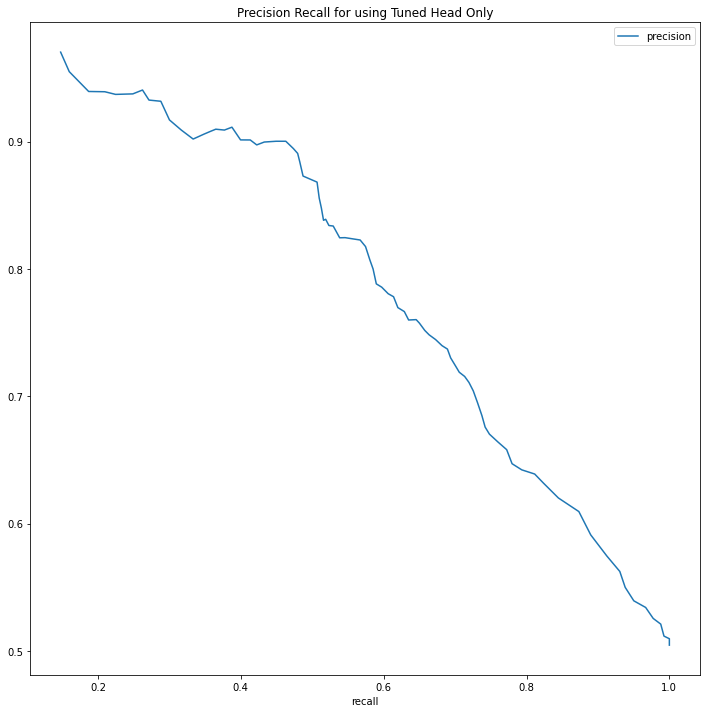

In [27]:
pr_df.plot(x = 'recall', y='precision', title='Precision Recall for using Tuned Head Only',figsize=(12,12))

## Prediction Recall Curves with FineTune

In [28]:
pr = []
for i in cutoffs:
    precision = get_precision(predictions_finetuned, i)
    recall = get_recall(predictions_finetuned,i)
    pr.append([recall, precision])

In [29]:
pr_df = pd.DataFrame(pr).rename(columns={0:'recall',1:'precision'}).dropna()

<AxesSubplot:title={'center':'Precision Recall for using Fully Trained Only'}, xlabel='recall'>

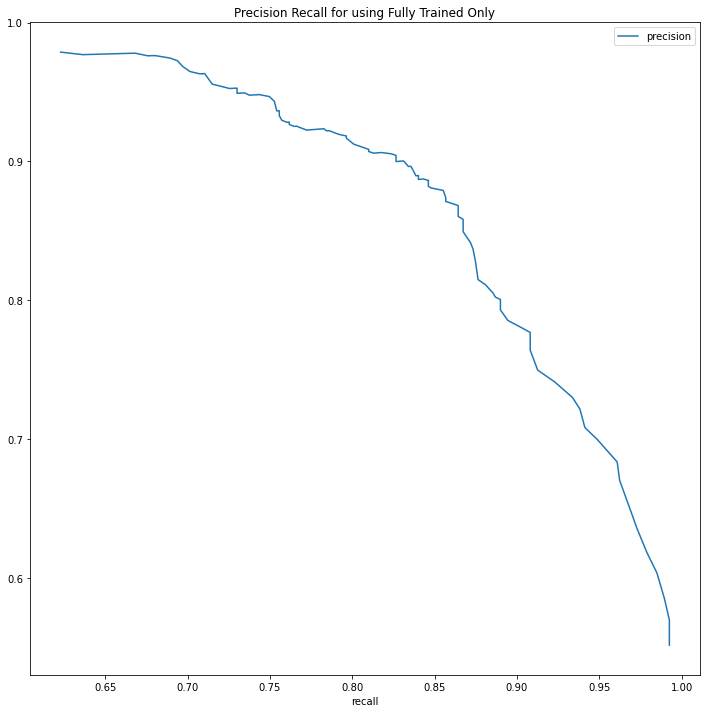

In [30]:
pr_df.plot(x = 'recall', y='precision', title='Precision Recall for using Fully Trained Only',figsize=(12,12))

## Checking ROC Curve for FineTune

In [31]:
norm = predictions_finetuned.predictions.max()
norm

0.9999985694885251

In [32]:
pred_fine_per = predictions_finetuned.assign(predictions_per = predictions_finetuned.predictions.apply(lambda x: x/norm))

In [33]:
fpr_f, tpr_f, thresholds_f = metrics.roc_curve(list(predictions_finetuned.labels),list(pred_fine_per.predictions_per))

## Checking ROC Curves for Head Only

In [34]:
predictions_head

,predictions,labels
0,0.475730,1
1,0.927136,1
2,0.802354,0
3,0.310956,0
4,0.879146,1
...,...,...
1309,0.986702,1
1310,0.283839,0
1311,0.615232,1
1312,0.309383,1


In [35]:
norm = predictions_head.predictions.max()

In [36]:
pred_head_per = predictions_head.assign(predictions_per = predictions_head.predictions.apply(lambda x: x/norm))

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(list(pred_head_per.labels),list(pred_head_per.predictions_per))

In [38]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)

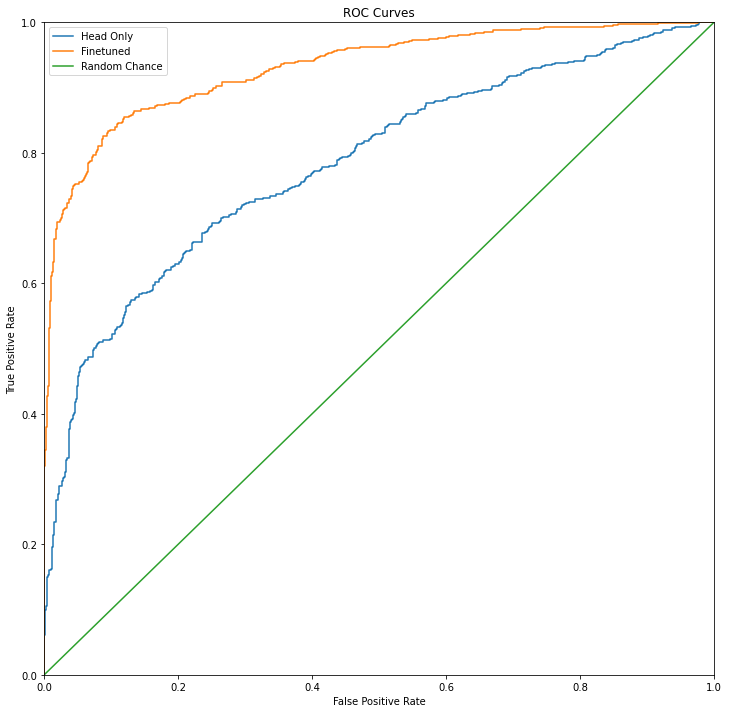

In [43]:
plt.figure(figsize=(12,12))
plt.plot(fpr,tpr)
plt.plot(fpr_f,tpr_f)
plt.plot(x,y)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0,1])
plt.ylim([0,1])
plt.title('ROC Curves')
plt.legend(['Head Only', 'Finetuned','Random Chance'])
plt.show()

This now looks most excellent!!

## True Positive Rates

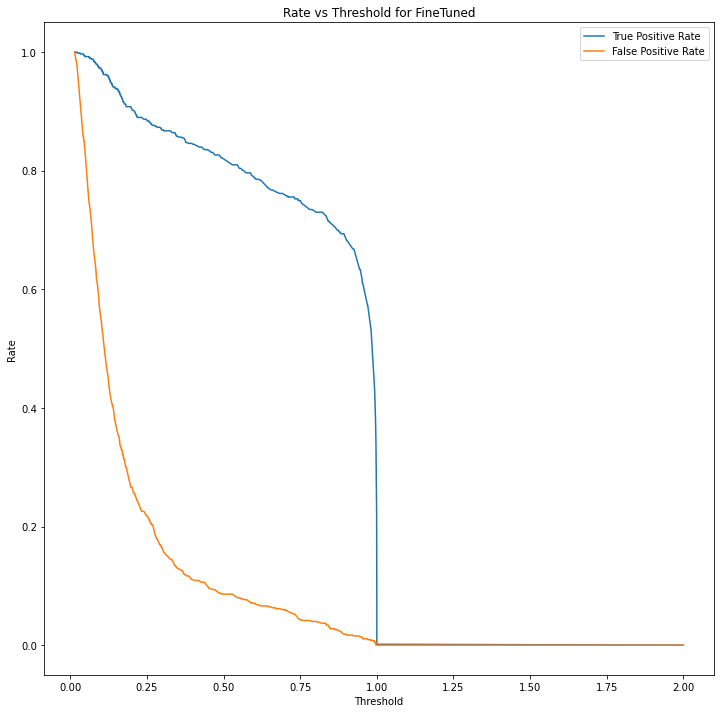

In [40]:
plt.figure(figsize=(12,12))
plt.plot(thresholds_f, tpr_f)
plt.plot(thresholds_f, fpr_f)
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('Rate vs Threshold for FineTuned')
plt.legend(['True Positive Rate', 'False Positive Rate'])
plt.show()